# Libraries

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import math
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from google.colab import files
import re

import warnings
warnings.filterwarnings('ignore')

# UTILS

## Sets of Features (aka data columns)

In [78]:
#Master Dataset
META_COL = ['clusters', 'new_clusters']
META_COL_VIZ = ['Error_Type']

ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL = ['age', 'decile_score', 'priors_count']
DUMMY_COL = ['sex_Female','race_African-American', 'race_Caucasian', 'race_Asian', 'race_Hispanic',
                      'race_Native American', 'race_Other']

ERROR_COL_scaled = ['errors_scaled']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_COL_scaled = ['sex_Female_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']
DUMMY_COL_scaled_light = ['sex_Female_scaled', 'race_African-American_scaled', 'race_Caucasian_scaled']

#SHAP is created on BASIC_COL_scaled and DUMMY_COL_scaled
SHAP_BASIC = ['Shap_age', 'Shap_decile_score', 'Shap_priors_count']
SHAP_DUMMY = ['Shap_sex_Female','Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
                         'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other']

SHAP_BASIC_scaled = ['Shap_age_scaled', 'Shap_decile_score_scaled', 'Shap_priors_count_scaled']
SHAP_DUMMY_scaled = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled',
                     'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled','Shap_race_Hispanic_scaled',
                     'Shap_race_Native American_scaled', 'Shap_race_Other_scaled']
SHAP_DUMMY_scaled_light = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled','Shap_race_Caucasian_scaled']




## Utils for Data Prep

In [79]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

In [80]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

## Utils for Clustering

In [81]:
# Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() from V1
# Does not work on scaled (binary) error features
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

In [82]:
def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[filter_tf]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)

## Utils for Results

### Recap

In [83]:
def make_recap(data_result, feature_set):
  # MAKE RECAP of cluster info
  # ...with error rates
  res = data_result[['clusters', 'errors']]

  # ...with cluster size
  temp = data_result[['clusters']]
  temp['count'] = 1
  recap = temp.groupby(['clusters'], as_index=False).sum()

  # ...with number of error
  recap['n_error'] = res.groupby(['clusters']).sum().astype(int)

  # ...with 1-vs-All error diff
  recap['error_rate'] = res.groupby(['clusters']).mean()
  # recap['std'] = (recap['error_rate'] * (1-recap['error_rate']))/recap['count']
  # recap['std'] = recap['std'].apply(np.sqrt)

  # Prepare Quality metrics
  diff_vs_rest = []
  # diff_std = []
  diff_p =[]

  race_aa_prop = []
  race_aa_diff = []
  race_aa_p = []

  race_c_prop = []
  race_c_diff = []
  race_c_p = []

  female_prop = []
  female_diff = []
  female_p = []

  silhouette = []

  # Get individual silhouette scores
  clusters = data_result['clusters']
  if(len(recap['clusters'].unique()) > 1):
    silhouette_val = silhouette_samples(data_result[feature_set], clusters)

  for c in recap['clusters']:
    # Get in-cluster data
    c_data = data_result.loc[data_result['clusters'] == c]
    c_count = recap['count'][c]

    # Get out-of-cluster data
    rest_data = data_result.loc[data_result['clusters'] != c]
    # Check if no other cluster
    if(len(rest_data) == 0):
      diff_vs_rest.append(np.nan)
      # diff_std.append(np.nan)
      diff_p.append(np.nan)

      race_aa_prop.append(np.nan)
      race_aa_diff.append(np.nan)
      race_aa_p.append(np.nan)

      race_c_prop.append(np.nan)
      race_c_diff.append(np.nan)
      race_c_p.append(np.nan)

      female_prop.append(np.nan)
      female_diff.append(np.nan)
      female_p.append(np.nan)

      silhouette.append(np.nan)
      break

    # Add silhouette score
    silhouette.append(silhouette_val[clusters == c].mean())

    rest_recap = recap.loc[recap['clusters'] != c]
    rest_count = rest_recap['count'].sum()

    #### Quick test: differences in error rates
    # Get error rate difference 1-vs-rest
    rest_n_error = rest_recap['n_error'].sum()
    rest_rate = rest_n_error / rest_count
    diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

    # ...with std deviation of error differences
    # std_rest = (rest_rate * (1-rest_rate))/rest_count
    # std_rest = np.sqrt(std_rest)
    # diff_std.append(recap['std'][c] + std_rest)

    # ...with Poisson stat testprint('Zero!')
    # Deal with splits with 0 error (by using either number of errors (FN or FP), or number of correct classifications (TP or TN))
    if((recap['n_error'][c] < 1) | (recap['count'][c] < 1) | (rest_n_error < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c], rest_count - rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))

    ##### Sensitive features (gender, race) -- ['sex_Female', 'race_African-American', 'race_Caucasian']]
    ### Race African-American (AA)
    rest_n_aa = rest_data['race_African-American'].sum()
    rest_prop_aa = rest_n_aa / rest_count

    c_n_aa = c_data['race_African-American'].sum()
    c_prop_aa = c_n_aa / c_count

    race_aa_prop.append(c_prop_aa)
    race_aa_diff.append(c_prop_aa - rest_prop_aa)

    # Deal with splits with 0 African-American (by using either number of AA, or number of non-AA)
    if((c_n_aa < 1) | (c_count < 1) | (rest_n_aa < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_aa, c_count, rest_count - rest_n_aa, rest_count)
      race_aa_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_aa, c_count, rest_n_aa, rest_count)
      race_aa_p.append(round(res.pvalue, 3))

    ### Race Caucasian
    rest_n_c = rest_data['race_Caucasian'].sum()
    rest_prop_c = rest_n_c / rest_count

    c_n_c = c_data['race_Caucasian'].sum()
    c_prop_c = c_n_c / c_count

    race_c_prop.append(c_prop_c)
    race_c_diff.append(c_prop_c - rest_prop_c)

    # Deal with splits with 0 African-American (by using either number of AA, or number of non-AA)
    if((c_n_c < 1) | (c_count < 1) | (rest_n_c < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_c, c_count, rest_count - rest_n_c, rest_count)
      race_c_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_c, c_count, rest_n_c, rest_count)
      race_c_p.append(round(res.pvalue, 3))

    ##### Gender
    rest_n_female = rest_data['sex_Female'].sum()
    rest_prop_female = rest_n_female/ rest_count

    c_n_female = c_data['sex_Female'].sum()
    c_prop_female = c_n_female / c_count

    female_prop.append(c_prop_female)
    female_diff.append(c_prop_female - rest_prop_female)

    # Deal with splits with 0 females(by using either number of females, or number of males)
    if((c_n_female < 1) | (c_count < 1) | (rest_n_female < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_female, c_count, rest_count - rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_female, c_count, rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))

  recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
  # recap['diff_std'] = np.around(diff_std, 3)
  recap['diff_p'] = diff_p

  recap['race_aa_prop'] = np.around(race_aa_prop, 3)
  recap['race_aa_diff'] = np.around(race_aa_diff, 3)
  recap['race_aa_p'] = race_aa_p

  recap['race_c_prop'] = np.around(race_c_prop, 3)
  recap['race_c_diff'] = np.around(race_c_diff, 3)
  recap['race_c_p'] = race_c_p

  recap['female_prop'] = np.around(female_prop, 3)
  recap['female_diff'] = np.around(female_diff, 3)
  recap['female_p'] = female_p

  recap['silhouette'] = silhouette

  recap['error_rate'] = np.around(recap['error_rate'] , 3)
  # recap['std'] = np.around(recap['std'] , 3)

  recap.rename(columns={'clusters':'c'}, inplace=True)
  #print(recap.sort_values(by=['diff_p']))

  return(recap)

### Chi-Square Tests

In [84]:
def make_chi_tests(results):
  chi_res = {'cond_descr': [],
            'cond_name': [],
            'error': [],
            'race_aa': [],
            'race_c': [],
            'gender': []}

  for i in range(0, len(results['cond_name'])):
    chi_res['cond_descr'].append(results['cond_descr'][i])
    chi_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    if(len(recap['diff_p']) == 1):
      chi_res['error'].append(np.nan)
      chi_res['race_aa'].append(np.nan)
      chi_res['race_c'].append(np.nan)
      chi_res['gender'].append(np.nan)
      continue

    # Test error differences
    test_data = recap[['count', 'n_error']].copy(deep=True)

    test_data['count'] = test_data['count'] - test_data['n_error']
    test_data = test_data.rename(columns={"count": "n_correct"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['error'].append(round(test_res.pvalue, 6))

    #print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test gender differences
    test_data = recap[['count', 'female_prop']].copy(deep=True)

    test_data['female_prop'] = round(test_data['count'] * test_data['female_prop'])
    test_data = test_data.rename(columns={"female_prop": "female_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['female_n']
    test_data = test_data.rename(columns={"count": "male_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['gender'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test Race AA differences
    test_data = recap[['count', 'race_aa_prop']].copy(deep=True)

    test_data['race_aa_prop'] = round(test_data['count'] * test_data['race_aa_prop'])
    test_data = test_data.rename(columns={"race_aa_prop": "race_aa_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['race_aa_n']
    test_data = test_data.rename(columns={"count": "race_not_aa_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['race_aa'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test Race Caucasian differences
    test_data = recap[['count', 'race_c_prop']].copy(deep=True)

    test_data['race_c_prop'] = round(test_data['count'] * test_data['race_c_prop'])
    test_data = test_data.rename(columns={"race_c_prop": "race_c_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['race_c_n']
    test_data = test_data.rename(columns={"count": "race_not_c_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['race_c'].append(test_res.pvalue)

    # print(test_data)
    # print(round(test_res.pvalue, 6))

  return(pd.DataFrame(chi_res))

### All Quality Metrics

In [85]:
def recap_quali_metrics(chi_res, results, exp_condition):
  all_quali = {'cond_descr': chi_res['cond_descr'],
            'cond_name': chi_res['cond_name'],
            'error': chi_res['error'],
            'race_aa': chi_res['race_aa'],
            'race_c': chi_res['race_c'],
            'gender': chi_res['gender'],
            'silhouette': []}

  for i in range(0, len(chi_res['cond_name'])):
    data = results['cond_res'][i]
    feature_set = exp_condition['feature_set'][i]
    clusters = data['clusters']
    recap = results['cond_recap'][i]
    if(len(recap['diff_p']) == 1):
      all_quali['silhouette'].append(np.nan)
      continue
    silhouette_indiv = silhouette_samples(data[feature_set], clusters)
    silhouette_avg = silhouette_indiv.mean()
    all_quali['silhouette'].append(silhouette_avg)

  return(pd.DataFrame(all_quali))

## UTILS for Viz

In [86]:
def tsne_plot_wClusters(data, title, perplexity, learning_rate, n_iter, alpha, size, tsne_columns, fig_prefix):
  # Extract features for t-SNE and drop other_columns
  tsne_features = data[tsne_columns]
  other_columns = [col for col in data.columns if col not in tsne_features]
  other_features = data[other_columns]

  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
  tsne_result = tsne.fit_transform(tsne_features)
  tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

  temp_dataset = tsne_df.join(other_features, how='left')

  # Create scatterplot using seaborn
  scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, s=size,
                                hue="clusters", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  plt.savefig(fig_prefix+re.sub(' +', '', title)+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

# K-MEANS CLUSTERING

In [87]:
def hbac_kmeans(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop = 0.05,
                min_acceptable_cluster_prop = 0.03,
                min_acceptable_error_diff = 0.01,
                max_iter=300):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
      kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[columns_to_use])
      candidate_cluster['new_clusters'] = kmeans.labels_

      # KEEP CLUSTER OR NOT
      # ...are cluster size large enough?
      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad split: too small')
        banned_clusters.append(x)
        continue

      # ...is error rate difference large enough?
      e0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      e1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if(abs(e0 - e1) < min_acceptable_error_diff):
        #print('Bad split: same error')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data

# SETUP EXPERIMENTS

### Prepare Data

In [88]:
data_shaper = pd.read_csv('https://raw.githubusercontent.com/MDankloff/ClusterCompas/main/Compas_error_shap.csv')

In [89]:
# Split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(data_shaper)
TNFP_data = subset_TN_FP(data_shaper)

In [90]:
# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()

### Set experimental conditions

In [91]:
##### HBAC parameters
min_splittable_cluster_prop = 0.05
min_acceptable_cluster_prop = 0.05
min_acceptable_error_diff = 0.005

In [92]:
##### Make and name the sets of features to experiment with
feature_set_name = []
feature_set_descr = []
feature_set = []

######### BASELINE HBAC
### Does adding SHAP help the clustering?
# Baseline (Mitzal-Radheka)
feature_set_name.append(f'+REG +SEN  -err     -shap')
feature_set_descr.append('Baseline')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light)

# Baseline with Error (Selma)
feature_set_name.append('+REG +SEN +ERR  -shap')
feature_set_descr.append('Baseline with Error')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light + ERROR_COL_scaled)

# Adding SHAP values to Baseline (Mirthe;)
feature_set_name.append('+REG +SEN  -err    +SHAP')
feature_set_descr.append('Baseline with SHAP')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light)

feature_set_name.append('+REG +SEN +ERR  +SHAP')
feature_set_descr.append('Baseline with SHAP & Error')
feature_set.append(BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light + ERROR_COL_scaled)


############ SHAP-ONLY HBAC
### Does SHAP alone allow to identify clusters?
# Using only SHAP values
feature_set_name.append('-reg    -sen    -err     +SHAP')
feature_set_descr.append('SHAP only')
feature_set.append(SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light)

feature_set_name.append('-reg    -sen    +ERR  +SHAP')
feature_set_descr.append('SHAP only with Error')
feature_set.append(SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light + ERROR_COL_scaled)



############ ONLY SENSITIVE FEATURES
### Do sensitive features alone allow to identify clusters?
# Using only Sensitive features
feature_set_name.append('-reg    +SEN  -err     -shap')
feature_set_descr.append('Sensitive features only')
feature_set.append(DUMMY_COL_scaled_light)

feature_set_name.append('-reg    +SEN +ERR   -shap')
feature_set_descr.append('Sensitive features with Error')
feature_set.append(DUMMY_COL_scaled_light + ERROR_COL_scaled)

### Does adding SHAP help the clustering based on sensitive features?
# Using Sensitive features with SHAP values
feature_set_name.append('-reg    +SEN  -err     +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP')
feature_set.append(DUMMY_COL_scaled_light + SHAP_DUMMY_scaled_light)

feature_set_name.append('-reg    +SEN +ERR  +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP & Error')
feature_set.append(DUMMY_COL_scaled_light + SHAP_DUMMY_scaled_light + ERROR_COL_scaled)

# Using only SHAP of Sensitive features
feature_set_name.append('-reg    -sen    -err     +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_DUMMY_scaled_light)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_DUMMY_scaled_light + ERROR_COL_scaled)


############ ONLY REGULAR FEATURES
#conditons without sensitive to check how much it explains the results
feature_set_name.append('+REG -sen    -err     -shap')
feature_set_descr.append('REG Only')
feature_set.append(BASIC_COL_scaled)

feature_set_name.append('+REG -sen    +ERR  -shap')
feature_set_descr.append('REG & ERROR')
feature_set.append(BASIC_COL_scaled + ERROR_COL_scaled)

feature_set_name.append('+REG -sen    -err     +SHAP_R')
feature_set_descr.append('REG & SHAP')
feature_set.append(SHAP_BASIC_scaled + BASIC_COL_scaled) # ERROR FIXED

feature_set_name.append('+REG -sen    +ERR  +SHAP_R')
feature_set_descr.append('REG, ERROR & SHAP')
feature_set.append(SHAP_BASIC_scaled + BASIC_COL_scaled + ERROR_COL_scaled) # ERROR FIXED

# Using only SHAP of Regular features
feature_set_name.append('-reg    -sen    -err     +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features')
feature_set.append(SHAP_BASIC_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features + Error')
feature_set.append(SHAP_BASIC_scaled + ERROR_COL_scaled)

exp_condition = pd.DataFrame({'feature_set_descr': feature_set_descr,
                              'feature_set_name': feature_set_name,
                              'feature_set': feature_set})
exp_condition

,feature_set_descr,feature_set_name,feature_set
0,Baseline,+REG +SEN -err -shap,"[age_scaled, decile_score_scaled, priors_count..."
1,Baseline with Error,+REG +SEN +ERR -shap,"[age_scaled, decile_score_scaled, priors_count..."
2,Baseline with SHAP,+REG +SEN -err +SHAP,"[age_scaled, decile_score_scaled, priors_count..."
3,Baseline with SHAP & Error,+REG +SEN +ERR +SHAP,"[age_scaled, decile_score_scaled, priors_count..."
4,SHAP only,-reg -sen -err +SHAP,"[Shap_age_scaled, Shap_decile_score_scaled, Sh..."
5,SHAP only with Error,-reg -sen +ERR +SHAP,"[Shap_age_scaled, Shap_decile_score_scaled, Sh..."
6,Sensitive features only,-reg +SEN -err -shap,"[sex_Female_scaled, race_African-American_scal..."
7,Sensitive features with Error,-reg +SEN +ERR -shap,"[sex_Female_scaled, race_African-American_scal..."
8,Sensitive features with SHAP,-reg +SEN -err +SHAP_S,"[sex_Female_scaled, race_African-American_scal..."
9,Sensitive features with SHAP & Error,-reg +SEN +ERR +SHAP_S,"[sex_Female_scaled, race_African-American_scal..."


# TNFP RESULTS


### Execute experiments

In [93]:
from ctypes import Array
results = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}
for i in range(0, len(exp_condition)):
  res = hbac_kmeans(TNFP_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

  recap = make_recap(res, exp_condition['feature_set'][i])

  results['cond_name'].append(exp_condition['feature_set_name'][i])
  results['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results['cond_res'].append(res)
  results['cond_recap'].append(recap)

### Chi-Square Tests TNFP data

In [94]:
chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz

,error,race_aa,race_c,gender
cond_name,,,,
+REG +SEN -err -shap,0.000000,0.000000,0.000000,0.000000
+REG +SEN +ERR -shap,0.000000,0.000000,0.000000,0.000000
+REG +SEN -err +SHAP,0.000000,0.000000,0.000000,0.000000
+REG +SEN +ERR +SHAP,0.000000,0.000000,0.000000,0.000000
-reg -sen -err +SHAP,0.161326,0.695897,0.405239,0.398855
-reg -sen +ERR +SHAP,0.791682,0.293574,0.215735,0.885583
-reg +SEN -err -shap,0.000000,0.000000,0.000000,0.000000
-reg +SEN +ERR -shap,0.000000,0.000000,0.000000,0.000000
-reg +SEN -err +SHAP_S,0.000001,0.000000,0.000000,0.000000


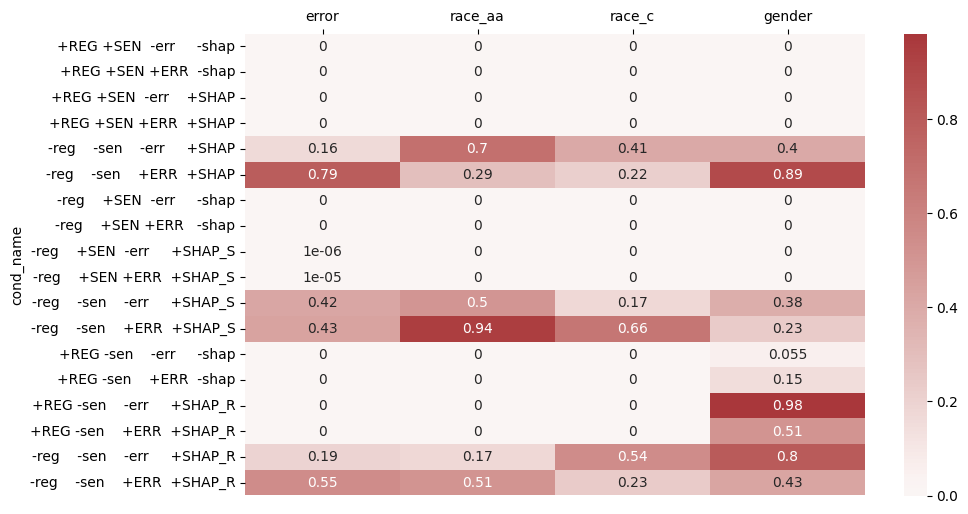

In [95]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

### All Quality Metrics TNFP data

In [96]:
all_quali = recap_quali_metrics(chi_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

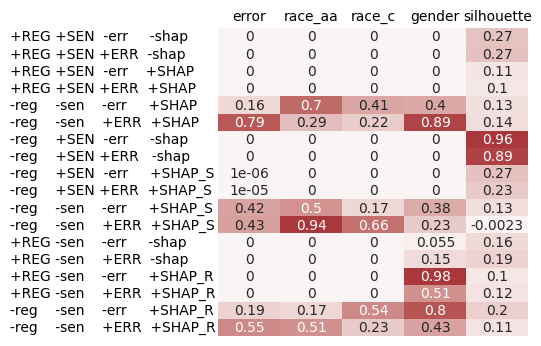

In [97]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TNFP_Kmeans.png', bbox_inches='tight', pad_inches=0)
files.download('TNFP_Kmeans.png')
plt.show()

# DETAILED TNFP RESULTS

## One-vs-All cluster comparison TNFP data

In [98]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,4))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## t-SNE TNFP data

In [99]:
for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TNFP_Kmeans_tSNE_')

Output hidden; open in https://colab.research.google.com to view.

# TPFN RESULTS

## Execute Experiments

In [100]:
from ctypes import Array
results = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}
for i in range(0, len(exp_condition)):
  res = hbac_kmeans(TPFN_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

  recap = make_recap(res, exp_condition['feature_set'][i])

  results['cond_name'].append(exp_condition['feature_set_name'][i])
  results['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results['cond_res'].append(res)
  results['cond_recap'].append(recap)

##Chi-Square Tests TPFN data

In [101]:
chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz

,error,race_aa,race_c,gender
cond_name,,,,
+REG +SEN -err -shap,0.000000,0.000000,0.000000,0.029357
+REG +SEN +ERR -shap,0.000000,0.000000,0.000000,0.010950
+REG +SEN -err +SHAP,0.000000,0.000000,0.000000,0.010402
+REG +SEN +ERR +SHAP,0.000000,0.000000,0.000000,0.113573
-reg -sen -err +SHAP,0.070878,0.892941,0.706312,0.893353
-reg -sen +ERR +SHAP,0.023312,0.187916,0.337231,0.988288
-reg +SEN -err -shap,0.000001,0.000000,0.000000,0.000000
-reg +SEN +ERR -shap,0.000065,0.000000,0.000000,0.000000
-reg +SEN -err +SHAP_S,0.000006,0.000000,0.000000,0.058076


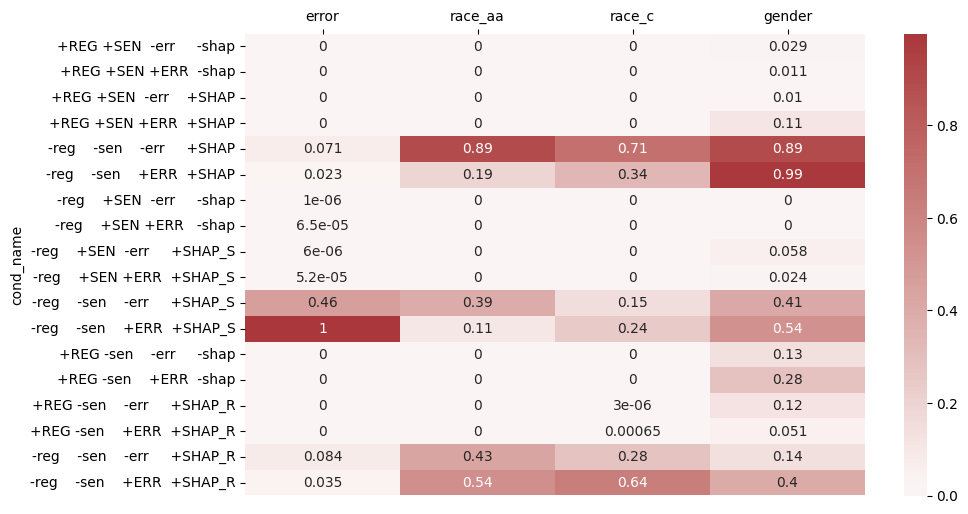

In [102]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

## All Quality Metrics TPFN data

In [103]:
all_quali = recap_quali_metrics(chi_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

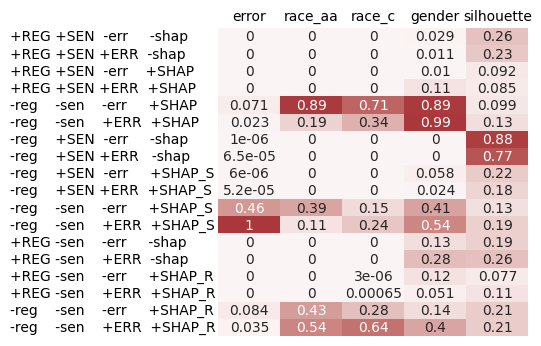

In [104]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TPFN_Kmeans.png', bbox_inches='tight', pad_inches=0)
files.download('TPFN_Kmeans.png')
plt.show()

# DETAILED TPFN data


## One-vs-All cluster comparison TPFN data

In [105]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,4))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TPFN_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## t-SNE TPFN data

In [106]:
for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TPFN_Kmeans_tSNE_')

Output hidden; open in https://colab.research.google.com to view.

# DOWNLOAD FIGURES

In [107]:
for i in range(0, 9):
  print(i)
  files.download('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')

0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
for i in range(9, 18):
  print(i)
  files.download('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')

9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
for i in range(0, 9):
  print(i)
  files.download('TNFP_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')

0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
for i in range(9, 18):
  print(i)
  files.download('TNFP_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')

9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [111]:
for i in range(0, 9):
  print(i)
  files.download('TPFN_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')

0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
for i in range(9, 18):
  print(i)
  files.download('TPFN_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')

9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
for i in range(0, 9):
  print(i)
  files.download('TPFN_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')

0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [114]:
for i in range(9, 18):
  print(i)
  files.download('TPFN_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')

9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>